# Trabajo Práctico N.° 3

## Imports y configs

In [2]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Análisis exploratorio sobre el conjunto de datos

Para que esto funcione, se debe bajar y descomprimir el archivo del siguiente [enlace](https://www.kaggle.com/jessicali9530/celeba-dataset). El mismo contiene:
* **img_align_celeba**: imágenes de rostros, recortadas y alineadas.
* **list_eval_partition.csv**: partición recomendada para las imagenes. Relaciona cada imagen con el atributo *partition*:
    * "0" si pertenece al conjunto de entrenamiento.
    * "1" si pertenece al conjunto de validación.
    * "2" si pertenece al conjunto de prueba.
* **list_bbox_celeba.csv**: información del cuadro delimitador para cada imagen.
* **list_landmarks_align_celeba.csv**: puntos de referencia (ojo izquierdo, ojo derecho, nariz, boca izquierda, boca derecha) y sus respectivas coordenadas.
* **list_attr_celeba.csv**: etiquetas (40 en total) de atributos para cada imagen. "1" representa positivo mientras que "-1" representa negativo.

En nuestro caso, utilizaremos las imágenes, *list_eval_partition.csv* y *list_attr_celeba.csv* para desarrollar un modelo que sea capaz de detectar si una persona tiene o no barba a partir de una foto. Entonces, nuestro target será el atributo *No_Beard*, que determina si una persona en una imagen no tiene barba.

In [3]:
# Modificar por la ruta donde se encuentran los archivos
current_path = '/home/matias/Documentos/archive/'
#current_path = '/home/yair/Files/archive/'

imgs_path = Path(current_path, 'img_align_celeba/img_align_celeba')
attr_path = Path(current_path, 'list_attr_celeba.csv')
partitions_path = Path(current_path, 'list_eval_partition.csv')

# Importamos y unimos los datasets de atributos y particiones
df_attr = pd.read_csv(attr_path, usecols=['image_id','No_Beard'])
df_partitions = pd.read_csv(partitions_path)
df = df_attr.merge(df_partitions, on="image_id", how="left")

df.sample(5)

,image_id,No_Beard,partition
11238,011239.jpg,1,0
161998,161999.jpg,1,0
137363,137364.jpg,1,0
58215,058216.jpg,-1,0
139449,139450.jpg,1,0


In [4]:
# Restablecemos los valores de la columna No_Beard
df.loc[df['No_Beard'] == -1,'No_Beard'] = "Barba"
df.loc[df['No_Beard'] == 1,'No_Beard'] = "No_Barba"

# Dividimos el dataframe en función de la columna partition
train = df.loc[df['partition'] == 0]
validation = df.loc[df['partition'] == 1]
test = df.loc[df['partition'] == 2]

# Eliminamos la columna partition de los 3 conjuntos
train = train.drop(['partition'],axis=1)
validation = validation.drop(['partition'],axis=1)
test = test.drop(['partition'],axis=1)

train.head(20)

,image_id,No_Beard
0,000001.jpg,No_Barba
1,000002.jpg,No_Barba
2,000003.jpg,No_Barba
3,000004.jpg,No_Barba
4,000005.jpg,No_Barba
5,000006.jpg,No_Barba
6,000007.jpg,No_Barba
7,000008.jpg,No_Barba
8,000009.jpg,No_Barba
9,000010.jpg,No_Barba


In [5]:
print("Cantidad total de imágenes:", len(df.image_id))
print("Cantidad de imágenes en train:", len(train.image_id))
print("Cantidad de imágenes en validation:", len(validation.image_id))
print("Cantidad de imágenes en test:", len(test.image_id))

Cantidad total de imágenes: 202599
Cantidad de imágenes en train: 162770
Cantidad de imágenes en validation: 19867
Cantidad de imágenes en test: 19962


## Volumetría de los datos

In [9]:
from PIL import Image

img_path = Path(str(imgs_path) + '/000002.jpg') # Este solo es un ejemplo
img = Image.open(img_path)

width, height = img.size
img_array = np.array(img)
depth = img_array.shape[2]

print(f'Alto de la imagen: {height} píxeles')
print(f'Ancho de la imagen: {width} píxeles')
print(f'Profundidad de la imagen (RGB): {depth}')

Alto de la imagen: 218 píxeles
Ancho de la imagen: 178 píxeles
Profundidad de la imagen (RGB): 3


## Distribución de la variable a predecir

In [10]:
category_count = df["No_Beard"].value_counts()
print(f'Cantidad total de imágenes de personas sin barba: {category_count.values[0]}')
print(f'Cantidad total de imágenes de personas con barba: {category_count.values[1]}')

Cantidad total de imágenes de personas sin barba: 169158
Cantidad total de imágenes de personas con barba: 33441


Text(0.5, 1.0, 'Test')

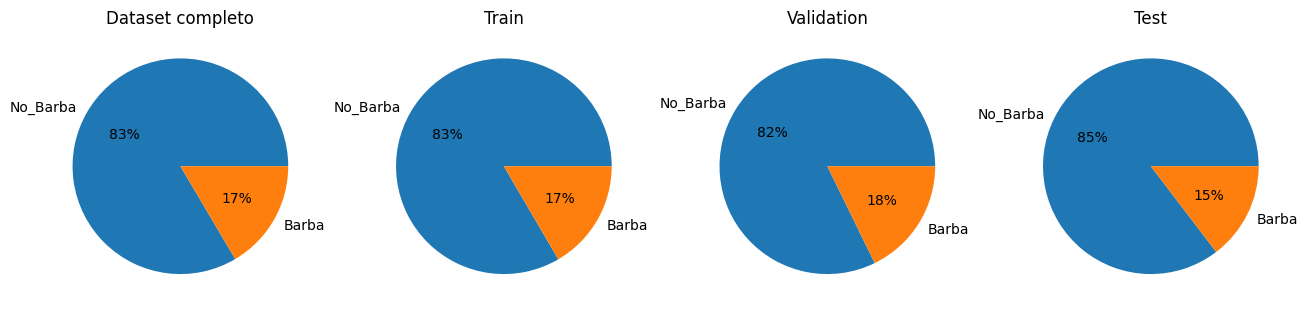

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))

df.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[0])
axs[0].set_title('Dataset completo')

train.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[1])
axs[1].set_title('Train')

validation.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[2])
axs[2].set_title('Validation')

test.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[3])
axs[3].set_title('Test')

Podemos concluir entonces que la métrica F1 es la que mejor se ajusta al problema ya que se tiene un conjunto de datos que se encuentra desbalanceado. Esto nos permite ponderar el rendimiento del modelo con respecto a los falsos positivos y falsos negativos.

## Estructura y tipo de las imágenes

Por cuestiones de tiempo de entrenamiento, vamos a aplicar cambios a las imágenes al armar los conjuntos de entrenamiento. Se va a reducir la dimensionalidad (alto y ancho), pasando de 218 x 178 píxeles a 64 x 64 píxeles.

In [6]:
# Rescalaremos los valores de las imágenes
datagen = ImageDataGenerator(
    rescale=1./255,
)
# Para crear datasets de imágenes para Keras
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 100
parameters = dict(
    x_col='image_id',
    y_col='No_Beard',
    target_size=(IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

# Generar datasets
train_generator = datagen.flow_from_dataframe(train, str(imgs_path) + "/",**parameters)
validation_generator = datagen.flow_from_dataframe(validation,str(imgs_path) + "/",**parameters)
test_generator = datagen.flow_from_dataframe(test, str(imgs_path) + "/",**parameters)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [7]:
# Obtener un bloque (imagenes y etiquetas)
train_imgs, train_labels = train_generator.next()

In [14]:
# Estructura de una imagen
train_imgs[0]

array([[[0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        ...,
        [0.8470589 , 0.86666673, 0.87843144],
        [0.8431373 , 0.86274517, 0.8745099 ],
        [0.8352942 , 0.854902  , 0.86666673]],

       [[0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        ...,
        [0.8470589 , 0.86666673, 0.87843144],
        [0.8431373 , 0.86274517, 0.8745099 ],
        [0.8431373 , 0.86274517, 0.8745099 ]],

       [[0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        [0.9725491 , 0.9725491 , 0.9725491 ],
        ...,
        [0.85098046, 0.8705883 , 0.882353  ],
        [0.8470589 , 0.86666673, 0.87843144],
        [0.854902  , 0.8745099 , 0.8862746 ]],

       ...,

       [[0.50980395, 0.5803922 , 0.6745098 ],
        [0.5019608 , 0.57254905, 0.6666667 ],
        [0.5019608 , 0

In [8]:
# Dibujar imagenes de ejemplo
def draw_images(dataset):
    cant_imgs = 15
    row_plt = 3
    col_plt = 5
    images, labels = dataset.next()
    for i in range(cant_imgs):
        ax = plt.subplot(row_plt, col_plt, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")

/home/matias/jupyter/jupyter/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


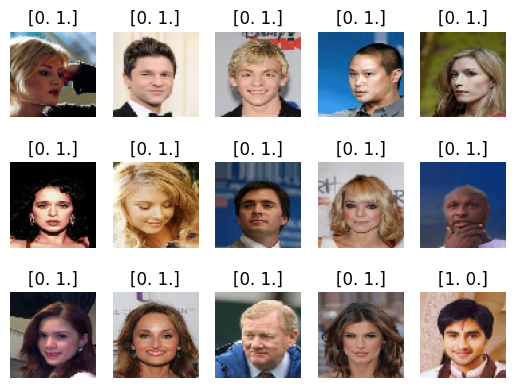

In [9]:
draw_images(train_generator)

En los ejemplos anteriores podemos visualizar imagenes de tipo:
* [0. 1.] indica que la persona no tiene barba.
* [1. 0.] indica que la persona tiene barba.

# Machine Learning

## Entrenamiento de modelos

Describir modelo 1

In [35]:
model_MPL_1 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_1 = model_MPL_1.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)


Epoch 1/10
   2/2712 [..............................] - ETA: 59:39 - loss: 1.1370 - accuracy: 0.5150  

KeyboardInterrupt: 

### Mostramos el historial

In [ ]:
plt.plot(history_MPL_1.history['accuracy'], label='train')
plt.plot(history_MPL_1.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()



In [ ]:
datasets = (
    ('train',train_generator),
    ('validation',validation_generator),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model_MPL_1.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('F1:', f1_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], rotation=45)
    plt.yticks([0, 1])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Describir modelo 2

In [ ]:
model_MPL_2 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_2 = model_MPL_2.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

### Mostrar historial

In [ ]:
plt.plot(history_MPL_2.history['accuracy'], label='train')
plt.plot(history_MPL_2.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Confussion matrix

In [ ]:
datasets = (
    ('train',train_generator),
    ('validation',validation_generator),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model_MPL_2.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('F1:', f1_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], rotation=45)
    plt.yticks([0, 1])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Describir metodo 3

In [26]:
model_MPL_3 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',],
)

BATCH_SIZE=20

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_3 = model_MPL_3.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
   9/8138 [..............................] - ETA: 2:49:19 - loss: 0.5609 - accuracy: 0.7322

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_MPL_3.history['accuracy'], label='train')
plt.plot(history_MPL_3.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confución

In [ ]:
datasets = (
    ('train',train_generator),
    ('validation',validation_generator),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model_MPL_2.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('F1:', f1_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], rotation=45)
    plt.yticks([0, 1])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Describir Modelo 4

In [15]:
model_MPL_4 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',],)

BATCH_SIZE=100

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_4 = model_MPL_4.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
  17/1627 [..............................] - ETA: 35:07 - loss: 0.5039 - accuracy: 0.8335

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_MPL_4.history['accuracy'], label='train')
plt.plot(history_MPL_4.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

In [ ]:
datasets = (
    ('train',train_generator),
    ('validation',validation_generator),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model_MPL_4.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('F1:', f1_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], rotation=45)
    plt.yticks([0, 1])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Describir modelo 5

In [28]:
model_MPL_5 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',],)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_5 = model_MPL_5.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
   1/2712 [..............................] - ETA: 2:28:16 - loss: 0.8018 - accuracy: 0.1500

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_MPL_5.history['accuracy'], label='train')
plt.plot(history_MPL_5.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

In [ ]:
datasets = (
    ('train',train_generator),
    ('validation',validation_generator),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model_MPL_5.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('F1:', f1_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], rotation=45)
    plt.yticks([0, 1])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Descripción modelo 6

In [ ]:
model_MPL_6 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(50,activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_6 = model_MPL_6.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

### Mostrar historial

In [ ]:
plt.plot(history_MPL_6.history['accuracy'], label='train')
plt.plot(history_MPL_6.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

Describir modelo 7

In [ ]:
model_MPL_6 = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',],
)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_6 = model_MPL_6.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=20, verbose = 1, callbacks=[OurCustomCallback()]
)

### Mostrar historial

In [ ]:
plt.plot(history_MPL_7.history['accuracy'], label='train')
plt.plot(history_MPL_7.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión 

Describir modelo 8

In [29]:
model_CVL_1 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_CVL_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy',],)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_1 = model_CVL_1.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
  11/2712 [..............................] - ETA: 58:42 - loss: 0.4348 - accuracy: 0.8636

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_CVL_1.history['accuracy'], label='train')
plt.plot(history_CVL_1.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Mostrar matriz de confusión

Describir modelo 9

In [ ]:
model_CVL_2 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_CVL_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',],)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_2 = model_CVL_2.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

### Mostrar historial

In [ ]:
plt.plot(history_CVL_2.history['accuracy'], label='train')
plt.plot(history_CVL_2.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

DEscrivir modelo 10

In [33]:
model_CVL_3 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='relu'),
    Convolution2D(filters=16, kernel_size=(4, 4), strides=1, activation='tanh'),
    Convolution2D(filters=16, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_CVL_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',],
)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_3 = model_CVL_3.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
  16/2712 [..............................] - ETA: 53:12 - loss: 0.5132 - accuracy: 0.8119

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_CVL_3.history['accuracy'], label='train')
plt.plot(history_CVL_3.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

### Transfer Learning

In [17]:
pretrained_model = VGG16(include_top=False, input_shape= IMAGE_SIZE + (3,))
pretrained_model.trainable = False

vgg16_model = Sequential(
    [
    pretrained_model,
    #Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    #MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

# Compile the model
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_vgg16 = vgg16_model.fit(
    train_generator, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
   4/1627 [..............................] - ETA: 1:10:38 - loss: 0.4767 - accuracy: 0.8350

KeyboardInterrupt: 

### Mostrar historial

In [ ]:
plt.plot(history_vgg16.history['accuracy'], label='train')
plt.plot(history_vgg16.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Graficar matriz de confusión

## Ampliación de datos

In [12]:
datagen_extra = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
)
    
train_generator_extra = datagen_extra.flow_from_dataframe(train, str(imgs_path) + "/",**parameters)

Found 162770 validated image filenames belonging to 2 classes.


In [13]:
imagenes_n, labels_n = train_generator.next()
imagenes_a, labels_a = train_generator_extra.next()

train_ampliado_imagenes = np.concatenate((
    imagenes_n,
    imagenes_a
))

train_ampliado_labels = np.concatenate((
    labels_n,
    labels_a
))

In [16]:
model_MPL_e = Sequential(
    [
    Flatten(),
    Dense(256,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
]
)

model_MPL_e.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_e = model_MPL_e.fit(
    train_ampliado_imagenes,train_ampliado_labels, validation_data = validation_generator
                        , validation_steps=len(validation)//BATCH_SIZE
                        ,steps_per_epoch=len(train)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1627/1627 [==============================] - 94s 57ms/step - loss: 0.7235 - accuracy: 0.7830 - val_loss: 0.4811 - val_accuracy: 0.8225
Epoch 2/10
1627/1627 [==============================] - 38s 24ms/step - loss: 0.4331 - accuracy: 0.8231 - val_loss: 0.5663 - val_accuracy: 0.8223


### Mostrar historial

### Graficar matriz de confusión

In [ ]:
def ImprimirMatriz(modelo):
    datasets = (
        ('train',train_generator),
        ('validation',validation_generator),
    )
    
    class_names=['Barba','No_Barba']

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        batch_images, batch_labels = dataset.next()
        print('Samples:', len(batch_images))
    
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        predictions = np.argmax(modelo.predict(batch_images), axis=-1)
        labels = np.argmax(batch_labels, axis=-1)
    
        print('F1:', f1_score(labels, predictions))
        
        print(f'F1 por clase:')
        f1_score_per_class = f1_score(labels, predictions, average=None)
        for label, score in zip(class_names, f1_score_per_class):
        print(f'\t - F1 para la clase {label}: {score}')

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))
        
        plt.xticks([0, 1], rotation=45)
        plt.yticks([0, 1])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [ ]:
ImprimirMatriz(history_MPL_e)

In [ ]:
print(classification_report(decoded_y_test,
                            decoded_predictions,
                            target_names=CIFAR_10_CLASSES))